In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Exploring and Analyzing Text Data Assignment 

In [2]:
import spacy
import string
import pandas as pd
from nltk import pos_tag
from nltk.text import Text
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


<IPython.core.display.Javascript object>

### Read the CNN Lite plain text file articles into a corpus using the NLTK's PlaintextCorpusReader.

In [3]:
DOC_PATTERN = r".*\.txt"
corpus = PlaintextCorpusReader("corpata/cnn_lite/", DOC_PATTERN)

<IPython.core.display.Javascript object>

### Iterate through the fileids in the corpus, extract the raw text of each document, and store them in a list.

In [4]:
docs = []
for fileid in corpus.fileids():
    document = corpus.raw(fileid)
    docs.append(document)

<IPython.core.display.Javascript object>

### Write a function that calculates the following statistics for a document and returns them as a list.

- Number of sentences
- Number of tokens
- Number of words (no stop words or punctuation)
- Number of unique words (vocabulary)
- Number of unique named entities (excluding numbers, dates, times, and currency types)
- Average sentence length
- Average word length
- Lexical diversity

In [25]:
def doc_stats(doc):
    numeric_types = [
        "DATE",
        "TIME",
        "PERCENT",
        "MONEY",
        "QUANTITY",
        "ORDINAL",
        "CARDINAL",
    ]
    sentences = sent_tokenize(doc)
    tokens = word_tokenize(doc)
    no_punct = [
        word.lower()
        for word in tokens
        if word.isalpha() == True
        if word.lower() not in stopwords.words("english")
    ]
    characters = sum([len(word) for word in no_punct])
    vocab = set(no_punct)
    spacy_doc = nlp(doc)

    entities = [
        [entity.text, entity.label_]
        for entity in spacy_doc.ents
        if entity.label_ not in numeric_types
    ]
    unique_ent = set([ent[0] for ent in entities])
    avg_sent_len = len(tokens) / len(sentences)
    avg_char = characters / len(no_punct)
    lex_div = len(vocab) / len(tokens)

    stats = {
        "num_sents": len(sentences),
        "num_tokens": len(tokens),
        "num_words": len(no_punct),
        "unique_entities": len(entities),
        "avg_sentence_length": avg_sent_len,
        "avg_word_length": avg_char,
        "lex_div": lex_div,
    }
    return stats

<IPython.core.display.Javascript object>

In [26]:
all_stats = []
for doc in docs:
    all_stats.append(doc_stats(doc))

<IPython.core.display.Javascript object>

### Iterate through all the documents, calculate these statistics for each one, and store all the results in a Pandas data frame.

In [31]:
corpus_stats = pd.DataFrame(all_stats)
corpus_stats["text"] = docs
corpus_stats.head()

,num_sents,num_tokens,num_words,unique_entities,avg_sentence_length,avg_word_length,lex_div,text
0,75,1654,743,94,22.053333,6.212651,0.310157,"Des Moines, Iowa (CNN) - Rep. Alexandria Ocasi..."
1,20,469,238,38,23.450000,6.571429,0.356077,Washington (CNN) - A federal appeals court on ...
2,262,4574,1909,155,17.458015,6.242535,0.232401,(CNN) - Bridge the gap. Cross the divide. Heal...
3,28,803,404,87,28.678571,6.358911,0.300125,Washington (CNN) - During a meeting in the Ova...
4,34,620,274,35,18.235294,6.383212,0.312903,(CNN) - A child prodigy from Belgium is on cou...


<IPython.core.display.Javascript object>

### Summarize these statistics for the entire corpus by calling the Pandas `describe` method.

In [32]:
corpus_stats.describe()

,num_sents,num_tokens,num_words,unique_entities,avg_sentence_length,avg_word_length,lex_div
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,51.385965,1025.228070,473.596491,68.508772,20.608343,6.341775,0.330933
std,69.758961,1218.008518,533.031521,76.181907,4.531385,0.371362,0.054657
min,4.000000,30.000000,15.000000,6.000000,7.500000,5.449612,0.162410
25%,18.000000,372.000000,168.000000,24.000000,17.937500,6.139098,0.299233
50%,26.000000,585.000000,285.000000,40.000000,20.666667,6.383212,0.332242
75%,63.000000,1297.000000,650.000000,82.000000,23.450000,6.592686,0.356077
max,423.000000,7635.000000,3254.000000,456.000000,29.875000,7.085561,0.466667


<IPython.core.display.Javascript object>

### Choose a document from the list of documents you created earlier and generate a frequency distribution bar chart for it showing which terms appear most frequently in the text.

<IPython.core.display.Javascript object>

In [37]:
doc = docs[2]
cleaned = [
    token.lower()
    for token in word_tokenize(doc)
    if token.lower() not in stopwords.words("English")
    if token.isalpha() == True
]

<IPython.core.display.Javascript object>

In [46]:
fdist = FreqDist(cleaned)
fdist_df = pd.DataFrame.from_dict(fdist, orient="index").reset_index()
fdist_df.columns = ["term", "freq"]
ordered = fdist_df.sort_values("freq", ascending=False)
filtered = ordered[ordered["freq"] > 1]

<IPython.core.display.Javascript object>

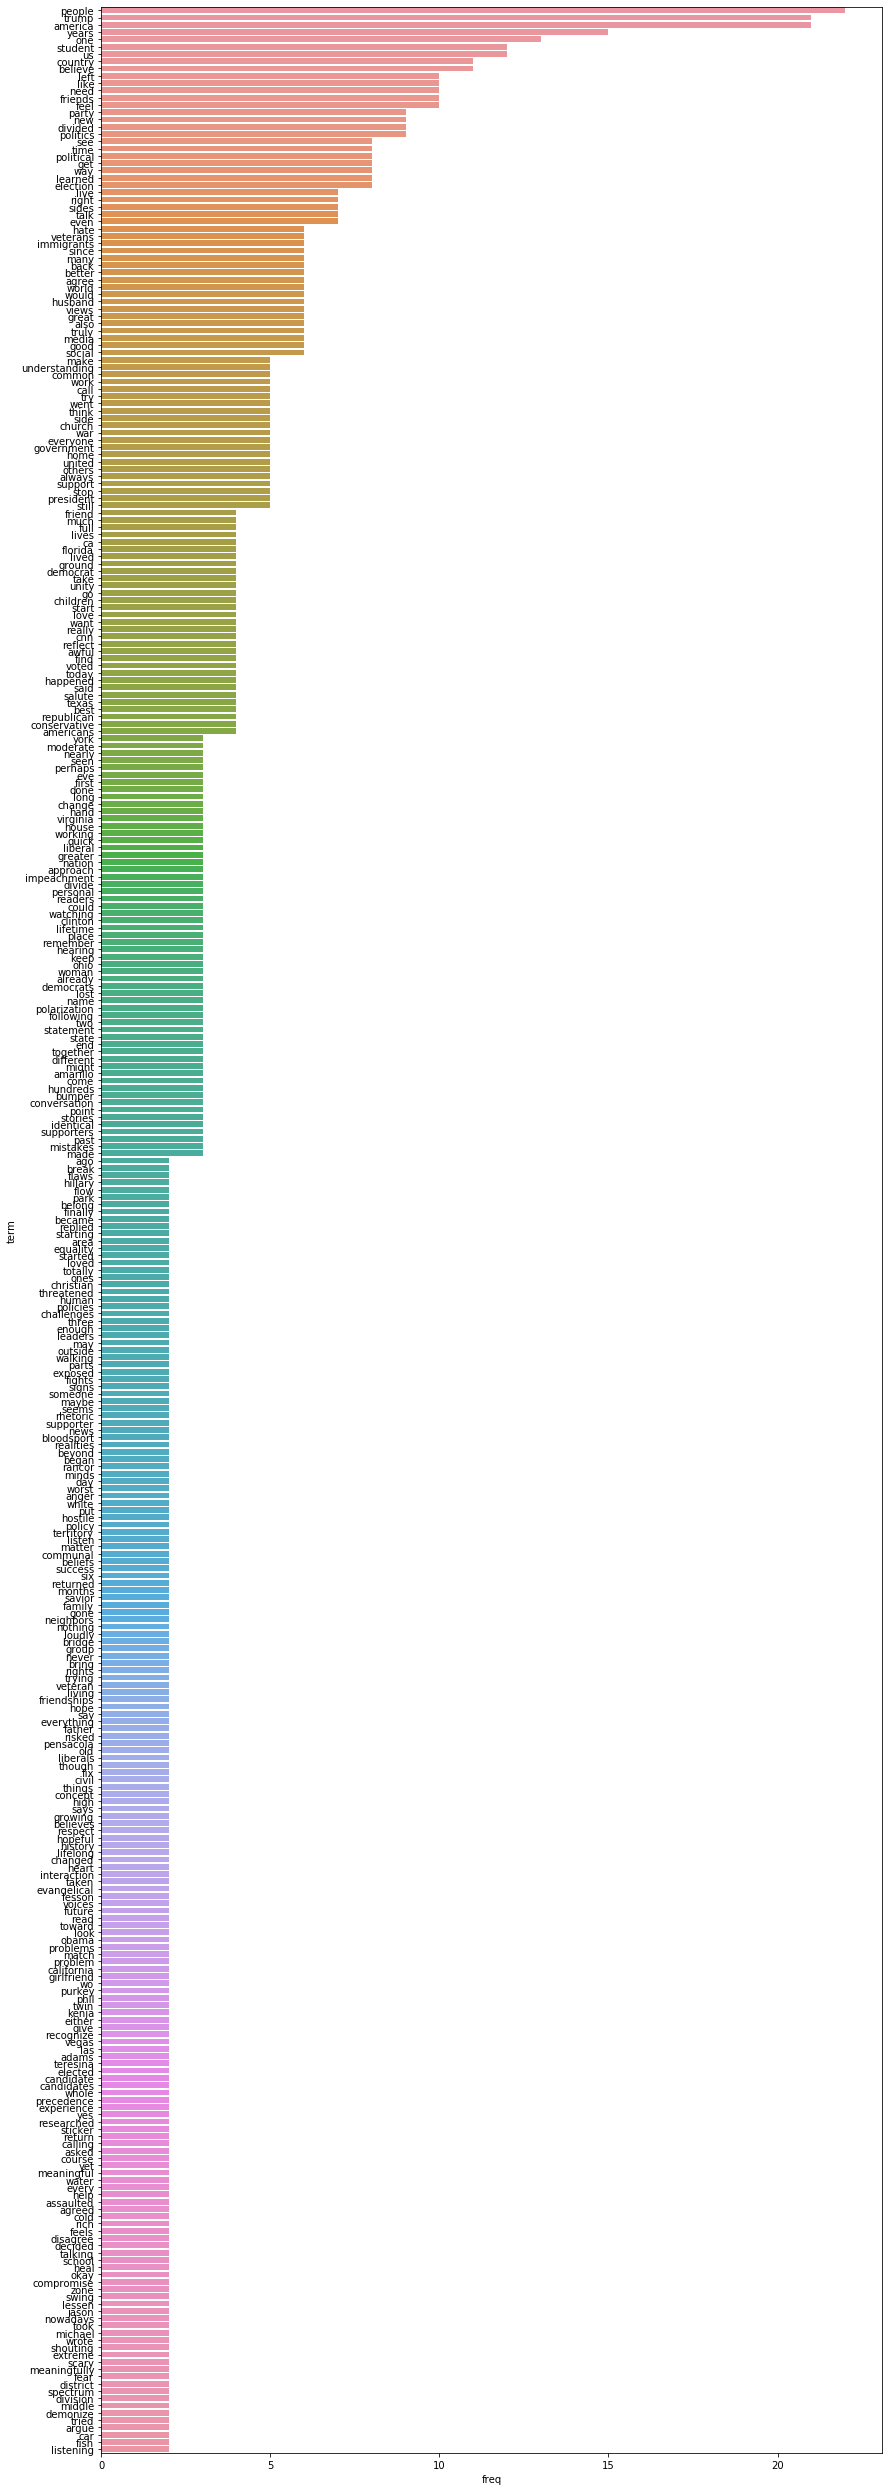

<IPython.core.display.Javascript object>

In [53]:
plt.figure(figsize=(14, 45))
sns.barplot(data=filtered, x="freq", y="term")

### Generate a word cloud visualization for the same document for which you generated the frequency distribution.

In [54]:
def word_cloud(text, colormap='tab10', background_color='white'):
    cloud = WordCloud(width=1600, height=800, stopwords=STOPWORDS,
                      colormap=colormap, 
                      background_color=background_color).generate(text)
    
    plt.figure(figsize=(12,10))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


<IPython.core.display.Javascript object>

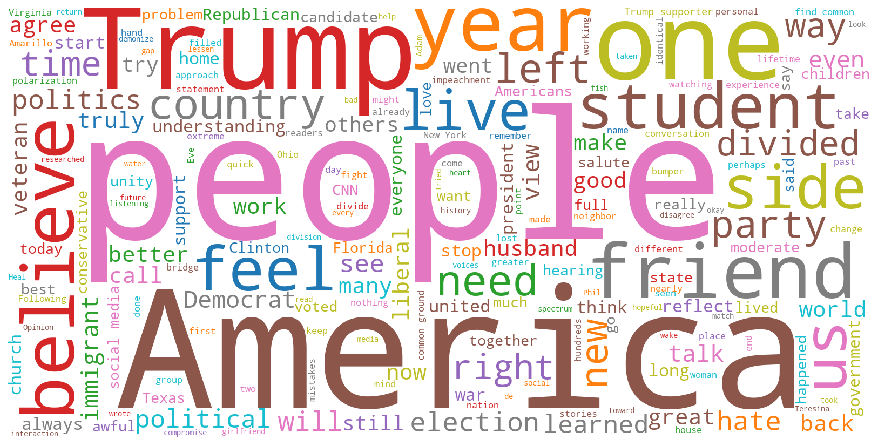

<IPython.core.display.Javascript object>

In [55]:
word_cloud(doc)

### Choose a different article (preferably one that references several named entities) and create a dispersion plot that shows the occurrence of those entities throughout the document.

In [83]:
corpus_stats.sort_values("unique_entities", ascending=False).head(10)

,num_sents,num_tokens,num_words,unique_entities,avg_sentence_length,avg_word_length,lex_div,text
7,423,7635,3254,456,18.049645,6.456976,0.162410,Washington (CNN) - President Donald Trump made...
41,257,3736,1892,298,14.536965,6.308668,0.213597,(CNN) - Here is a list of incidents of element...
20,104,2056,925,186,19.769231,6.677838,0.272374,(CNN) - The House Intelligence Committee opene...
51,73,1341,718,172,18.369863,6.789694,0.282625,(CNN) - The impeachment inquiry centers on cla...
2,262,4574,1909,155,17.458015,6.242535,0.232401,(CNN) - Bridge the gap. Cross the divide. Heal...
14,66,1607,793,152,24.348485,6.592686,0.334785,Washington (CNN) - Dramatic new disclosures on...
30,74,1548,780,147,20.918919,6.797436,0.306848,Washington (CNN) - The first public impeachmen...
22,103,1817,808,133,17.640777,6.118812,0.267474,New York (CNN Business) - A version of this ar...
42,66,1486,770,127,22.515152,7.040260,0.351279,Editor's Note: Paul Callan is a CNN legal anal...
46,70,1461,671,117,20.871429,6.542474,0.277892,Washington (CNN) - Thirty-eight minutes into h...


<IPython.core.display.Javascript object>

In [88]:
doc = docs[7]

<IPython.core.display.Javascript object>

In [89]:
spacy_doc = nlp(doc)
entities = [
    [entity.text, entity.label_]
    for entity in spacy_doc.ents
    if entity.label_ in ["PERSON"]
]
figures = list(set([ent[0] for ent in entities]))

<IPython.core.display.Javascript object>

In [90]:
Text(tokenized).dispersion_plot

<bound method Text.dispersion_plot of <Text: Washington ( CNN ) - Thirty-eight minutes into...>>

<IPython.core.display.Javascript object>

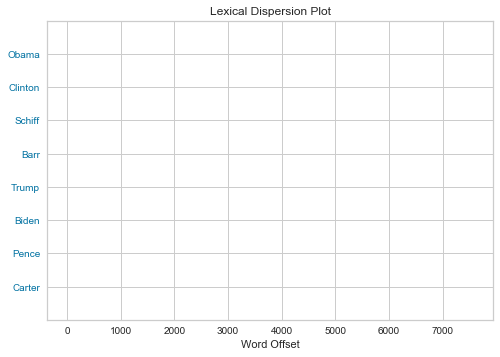

<IPython.core.display.Javascript object>

In [92]:
tokenized = word_tokenize(doc)
figures = ["Obama", "Clinton", "Schiff", "Barr", "Trump", "Biden", "Pence", "Carter"]

Text(tokenized).dispersion_plot(figures)

### Choose another article and generate a POS visualization highlighting the parts of speech for tokens in the article.

In [56]:
from yellowbrick.text.postag import PosTagVisualizer

<IPython.core.display.Javascript object>

In [95]:
dir(visualizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ax',
 '_fig',
 '_get_param_names',
 '_get_tags',
 '_handle_treebank',
 '_handle_universal',
 '_make_tag_map',
 '_more_tags',
 '_parser',
 '_penn_tag_map',
 '_size',
 '_uni_tag_map',
 'ax',
 'color',
 'colormap',
 'colors',
 'draw',
 'fig',
 'finalize',
 'fit',
 'fit_transform',
 'fit_transform_show',
 'frequency',
 'get_params',
 'parse_nltk',
 'parse_spacy',
 'parser',
 'poof',
 'punct_tags',
 'set_params',
 'set_title',
 'show',
 'size',
 'stack',
 'tagset',
 'tagset_names',
 'title',
 'transform']

<IPython.core.display.Javascript object>

In [118]:
visualizer.colors

TypeError: 'NoneType' object is not callable

<IPython.core.display.Javascript object>

In [126]:
tagged_list = [[tag[0], tag[1]] for tag in tagged]

<IPython.core.display.Javascript object>

In [129]:
visualizer.transform(tagged_list)

[['(', '('],
 ['CNN', 'NNP'],
 [')', ')'],
 ['-', ':'],
 ['The', 'DT'],
 ['impeachment', 'NN'],
 ['inquiry', 'NN'],
 ['centers', 'NNS'],
 ['on', 'IN'],
 ['claims', 'NNS'],
 ['that', 'IN'],
 ['President', 'NNP'],
 ['Donald', 'NNP'],
 ['Trump', 'NNP'],
 ['used', 'VBD'],
 ['US', 'NNP'],
 ['tax', 'NN'],
 ['dollars', 'NNS'],
 ['as', 'IN'],
 ['bait', 'NN'],
 ['to', 'TO'],
 ['pressure', 'VB'],
 ['Ukrainian', 'JJ'],
 ['President', 'NNP'],
 ['Volodymyr', 'NNP'],
 ['Zelensky', 'NNP'],
 ['to', 'TO'],
 ['open', 'VB'],
 ['investigations', 'NNS'],
 ['that', 'WDT'],
 ['could', 'MD'],
 ['damage', 'VB'],
 ['former', 'JJ'],
 ['Vice', 'NNP'],
 ['President', 'NNP'],
 ['Joe', 'NNP'],
 ['Biden', 'NNP'],
 ['heading', 'VBG'],
 ['into', 'IN'],
 ['the', 'DT'],
 ['2020', 'CD'],
 ['election', 'NN'],
 ['.', '.'],
 ['Below', 'IN'],
 ['are', 'VBP'],
 ['the', 'DT'],
 ['key', 'JJ'],
 ['dates', 'NNS'],
 ['in', 'IN'],
 ['the', 'DT'],
 ['Democratic', 'JJ'],
 ['case', 'NN'],
 ['.', '.'],
 ['For', 'IN'],
 ['more', 'JJR'],


<IPython.core.display.Javascript object>

In [120]:
doc = docs[51]
tokens = word_tokenize(doc)
tagged = pos_tag(tokens)

visualizer = PosTagVisualizer()
visualizer.transform(tagged)

print(
    " ".join((visualizer.colorize(token, color) for color, token in visualizer.tagged))
)
print("\n")

AttributeError: 'PosTagVisualizer' object has no attribute 'tagged'

<IPython.core.display.Javascript object>

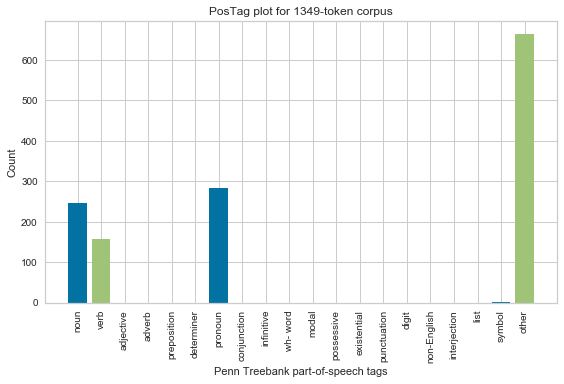

<IPython.core.display.Javascript object>

In [130]:
untagged_speech = doc

# Create the visualizer, fit, score, and show it
viz = PosTagVisualizer(parser="spacy")
viz.fit(untagged_speech)
viz.show()